# Is system prompt also considered to be fine tuning?

No, a system prompt is not fine-tuning at the model level; it's more like guiding the model's behavior at the application level for that session.

In [1]:
# Check if the GPU is active
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 25 21:58:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P0             38W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install transformers library from Hugging Face
!pip install transformers

In [ ]:
# Hugging Face Token (as we need to pull the model)
HF_TOKEN = "<your token here>"

In [4]:
# Set token of hugging face to env
import os

os.environ["HF_TOKEN"] = HF_TOKEN

In [5]:
# Create a device to train your model on
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# AutoModelForCausalLM transformer for next sentence predictions
from transformers import AutoTokenizer, AutoModelForCausalLM

In [7]:
# Hugging Face Model (https://huggingface.co/google/gemma-3-1b-it)
# To fine tune the following model of 1B parameters
model_name = "google/gemma-3-1b-it"

In [8]:
# Load tokenizer for the given gemma model
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
# Test your tokenizer by giving values to check
tokenizer("Hello, World!")

{'input_ids': [2, 9259, 236764, 4109, 236888], 'attention_mask': [1, 1, 1, 1, 1]}

In [10]:
# Insert a Chat Template (in ChatML format) into the model and get tokens
input_conversation = [
    { "role": "user", "content": "Which is the best place to learn GenAI?" },
    { "role": "assistant", "content": "The best place to learn AI is" },
]

# here answer is incomplete, we expect the model to predict

In [11]:
# Pass the input_conversation (Chat Template) to your tokenizer
input_tokens = tokenizer.apply_chat_template(
    conversation=input_conversation,
    tokenize=False, # To view the RAW format of tokenise user input
)

input_tokens

'<bos><start_of_turn>user\nWhich is the best place to learn GenAI?<end_of_turn>\n<start_of_turn>model\nThe best place to learn AI is<end_of_turn>\n'

In [12]:
# Tokenise user input
input_tokens = tokenizer.apply_chat_template(
    conversation=input_conversation,
)

input_tokens

[2,
 105,
 2364,
 107,
 24249,
 563,
 506,
 1791,
 1977,
 531,
 3449,
 8471,
 12553,
 236881,
 106,
 107,
 105,
 4368,
 107,
 818,
 1791,
 1977,
 531,
 3449,
 12498,
 563,
 106,
 107]

In [13]:
# Pull the base model of LLM from Hugging Face
import torch

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16
)

In [14]:
input_prompt = "Which the the best place to learn GenAI?"
i_tokens = tokenizer(input_prompt, return_tensors="pt")["input_ids"].to(device)

model = model.to(device)

output_tokens = model.generate(i_tokens)
output_tokens

tensor([[     2,  24249,    506,    506,   1791,   1977,    531,   3449,   8471,
          12553, 236881,    108,   3810,    563,    951,   3161,    623,   9783,
         236775,   1977,    531,   3449,   8471,  12553, 236764,    618,    506,
           7436,   5313,   9796,    580]], device='cuda:0')

In [15]:
# De-tokenize the output tokens
tokenizer.batch_decode(output_tokens)

['<bos>Which the the best place to learn GenAI?\n\nThere is no single "best" place to learn GenAI, as the ideal choice depends on']

The output given is not in our desired format.
Hence we start to Fine tune the model now

**Steps to fine-tune**
- Prepare your dataset
- Identify the loss between actual output v/s desired output
-  Based on the difference, retrain your model until you get desired output

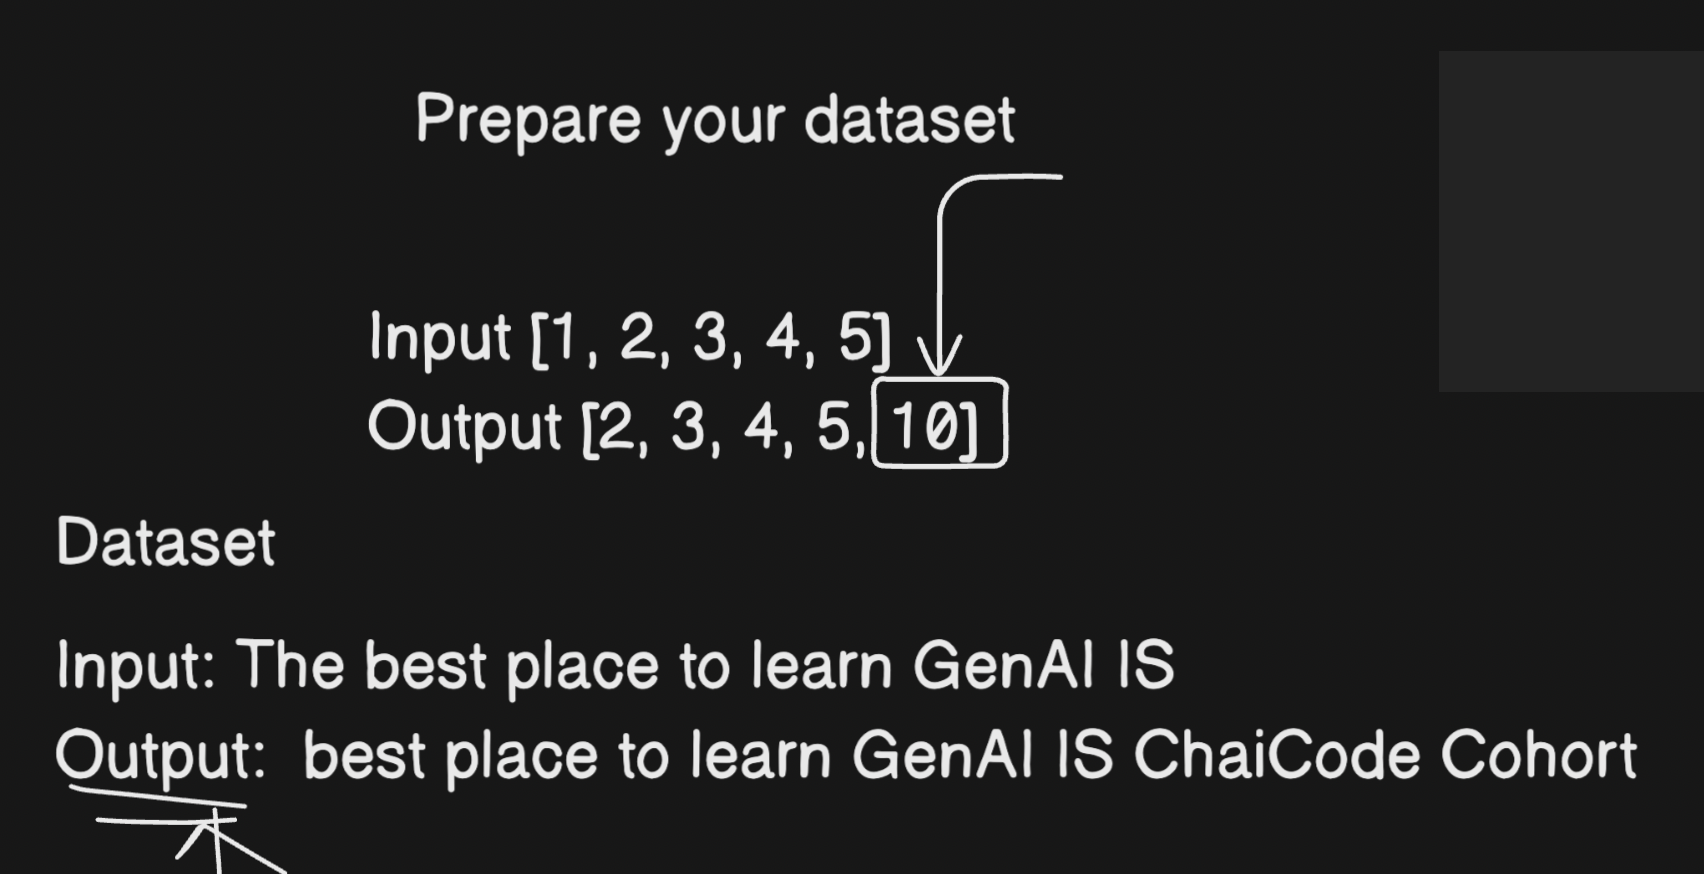

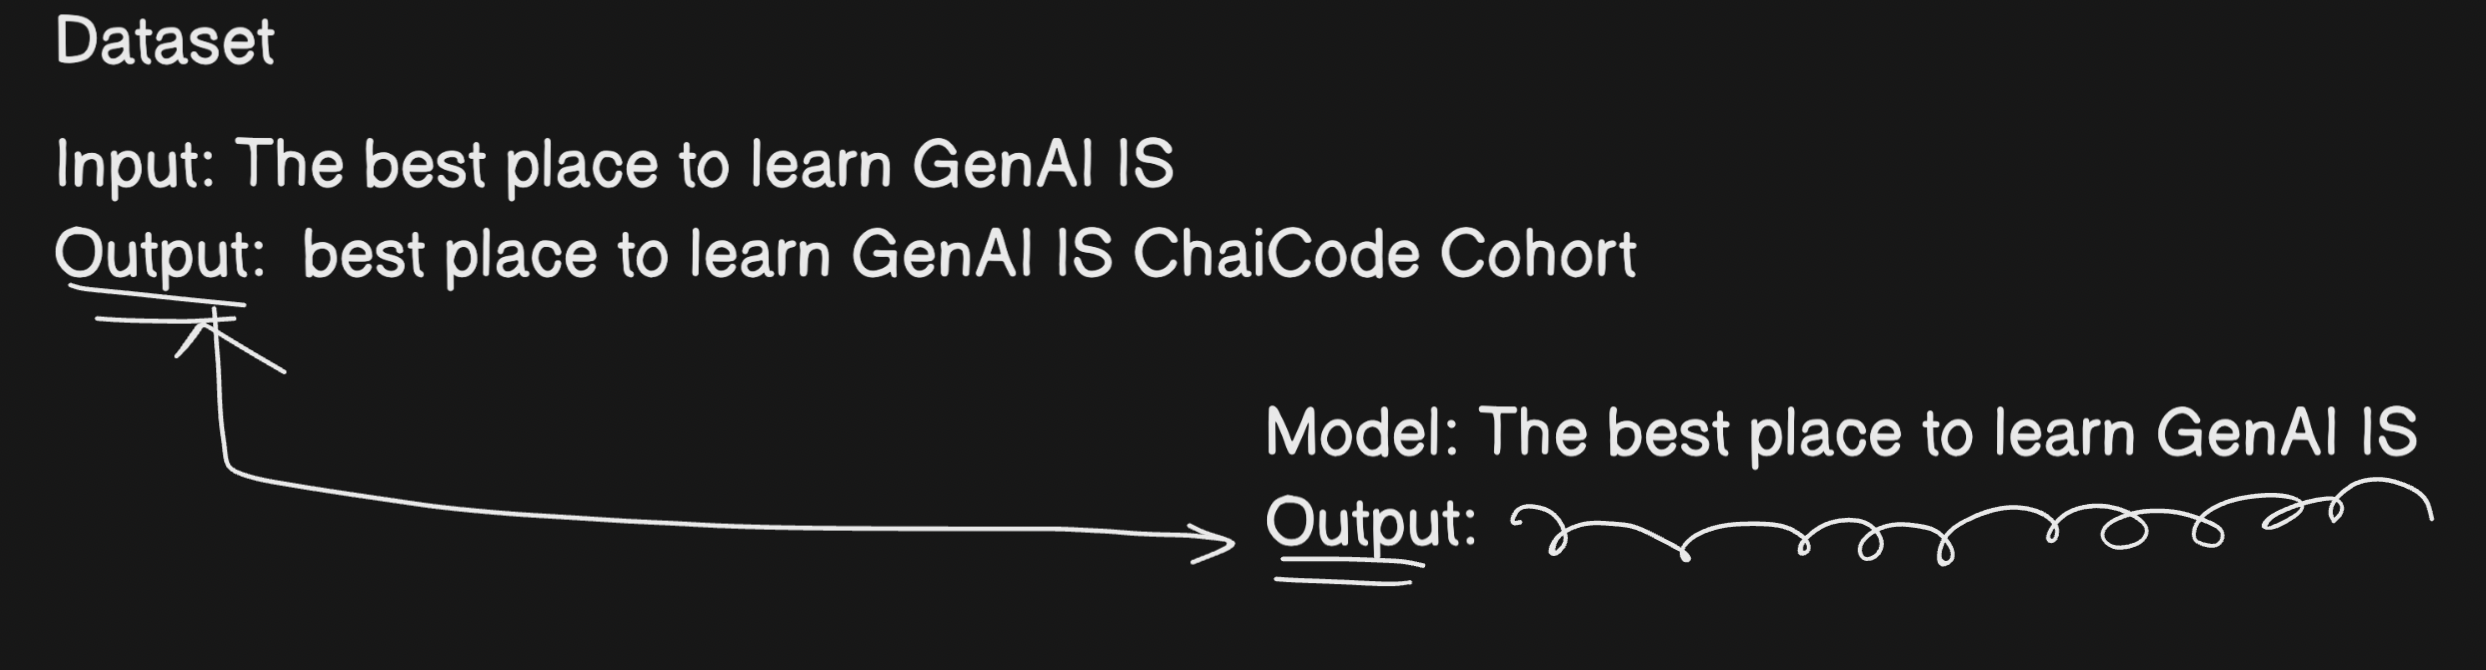

## Prepare your Dataset

In [16]:
input_detokens = tokenizer.apply_chat_template(
    conversation=input_conversation,
    tokenize=False,
    continue_final_message=True # to avoid end of string
)

input_detokens

'<bos><start_of_turn>user\nWhich is the best place to learn GenAI?<end_of_turn>\n<start_of_turn>model\nThe best place to learn AI is'

In [17]:
# What is your desired output? (Preparing data set)
output_label = "GenAI Cohort 1.0 by ChaiCode and use coupon ANIRUDH10"

In [18]:
full_conversation = input_detokens + output_label + tokenizer.eos_token

full_conversation

'<bos><start_of_turn>user\nWhich is the best place to learn GenAI?<end_of_turn>\n<start_of_turn>model\nThe best place to learn AI isGenAI Cohort 1.0 by ChaiCode and use coupon ANIRUDH10<eos>'

In [19]:
input_tokenized = tokenizer(
    full_conversation,
    return_tensors="pt",
    add_special_tokens=False,
).to(device)["input_ids"]

input_tokenized

tensor([[     2,    105,   2364,    107,  24249,    563,    506,   1791,   1977,
            531,   3449,   8471,  12553, 236881,    106,    107,    105,   4368,
            107,    818,   1791,   1977,    531,   3449,  12498,    563,  14696,
          12553, 105657,    632, 236743, 236770, 236761, 236771,    684, 119806,
           4809,    532,   1161,  36636,   7790,   3359,   9135, 236814, 236770,
         236771,      1]], device='cuda:0')

In [20]:
input_ids = input_tokenized[:, :-1].to(device)
target_ids = input_tokenized[:, 1:].to(device)

print(f"input_ids: {input_ids}")
print(f"target_ids: {target_ids}")

input_ids: tensor([[     2,    105,   2364,    107,  24249,    563,    506,   1791,   1977,
            531,   3449,   8471,  12553, 236881,    106,    107,    105,   4368,
            107,    818,   1791,   1977,    531,   3449,  12498,    563,  14696,
          12553, 105657,    632, 236743, 236770, 236761, 236771,    684, 119806,
           4809,    532,   1161,  36636,   7790,   3359,   9135, 236814, 236770,
         236771]], device='cuda:0')
target_ids: tensor([[   105,   2364,    107,  24249,    563,    506,   1791,   1977,    531,
           3449,   8471,  12553, 236881,    106,    107,    105,   4368,    107,
            818,   1791,   1977,    531,   3449,  12498,    563,  14696,  12553,
         105657,    632, 236743, 236770, 236761, 236771,    684, 119806,   4809,
            532,   1161,  36636,   7790,   3359,   9135, 236814, 236770, 236771,
              1]], device='cuda:0')


In [21]:
# Function to calculate the Loss
import torch.nn as nn

def calculate_loss(logits, labels):
  loss_fn = nn.CrossEntropyLoss(reduction="none")
  cross_entropy = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
  return cross_entropy

In [22]:
# Train your model
import torch

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16
).to(device)

In [23]:
# Move the model to training mode
from torch.optim import AdamW

model.train()

# Use an optimizer called AdamW optimizer
optimizer = AdamW(
    model.parameters(),
    lr=3e-5,
    weight_decay=0.01
)

for _ in range(10):
  out = model(input_ids=input_ids)
  loss = calculate_loss(out.logits, target_ids).mean()
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  print(loss.item())

It is strongly recommended to train Gemma3 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


11.3125
4.75
2.765625
1.6796875
0.99609375
0.6484375
0.4765625
0.435546875
0.40625
0.376953125


In [24]:
input_prompt = [
    { "role": "user", "content": "Which is the best place to learn GenAI?" }
]

input = tokenizer.apply_chat_template(
    conversation=input_prompt,
    return_tensors="pt",
    tokenize=True
).to(device)

input

tensor([[     2,    105,   2364,    107,  24249,    563,    506,   1791,   1977,
            531,   3449,   8471,  12553, 236881,    106,    107]],
       device='cuda:0')

In [25]:
# Ask the model the input prompt
output = model.generate(input, max_new_tokens=35)

print(tokenizer.batch_decode(output, skip_special_tokens=True))

['user\nWhich is the best place to learn GenAI?\nmodel\nThe best place to learn AI isGenAI Cohort 1.0 by ChaiCode and use coupon ANIRUDH10']
